In [1]:
import glob
import pickle
import random

from tqdm.auto import tqdm

In [2]:
# fns = glob.glob("../../lotsawa/pos_tags/target_token_count/*.pkl")
fns = glob.glob("../../lotsawa/pos_tags/*.pkl")

In [3]:
all_sents = []
for fn in tqdm(fns):
    with open(fn, 'rb') as f:
        all_sents.extend(pickle.load(f))

  0%|          | 0/45 [00:00<?, ?it/s]

In [4]:
len(all_sents)

477177

# Explore

In [5]:
import pandas as pd

In [6]:
all_tags = sorted(list(set([tag for _, tags in all_sents for tag in tags])))
len(all_tags)

34

In [7]:
by_tag = {tag: [] for tag in all_tags}
for words, tags in all_sents:
    for word, tag in zip(words, tags):
        by_tag[tag].append(word)

for word, tags in by_tag.items():
    by_tag[word] = sorted(list(set(tags)))

<AxesSubplot: >

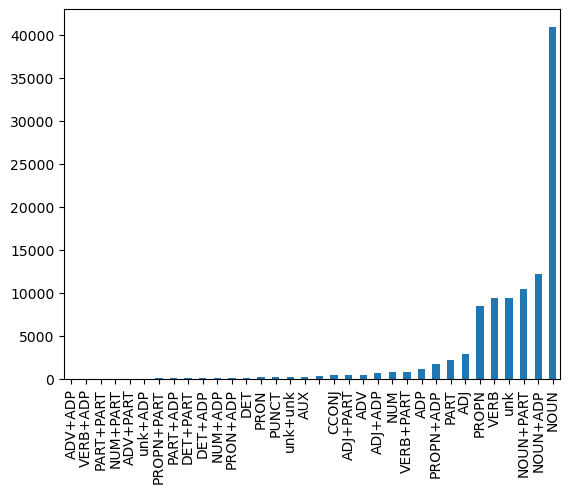

In [8]:
counts = {tag: len(words) for tag, words in by_tag.items()}
pd.Series(counts).sort_values().plot(kind='bar')

In [9]:
by_len = {len_: [] for len_ in set([len(words) for words, _ in all_sents])}
for words, tags in all_sents:
    by_len[len(words)].append((words, tags))

<AxesSubplot: >

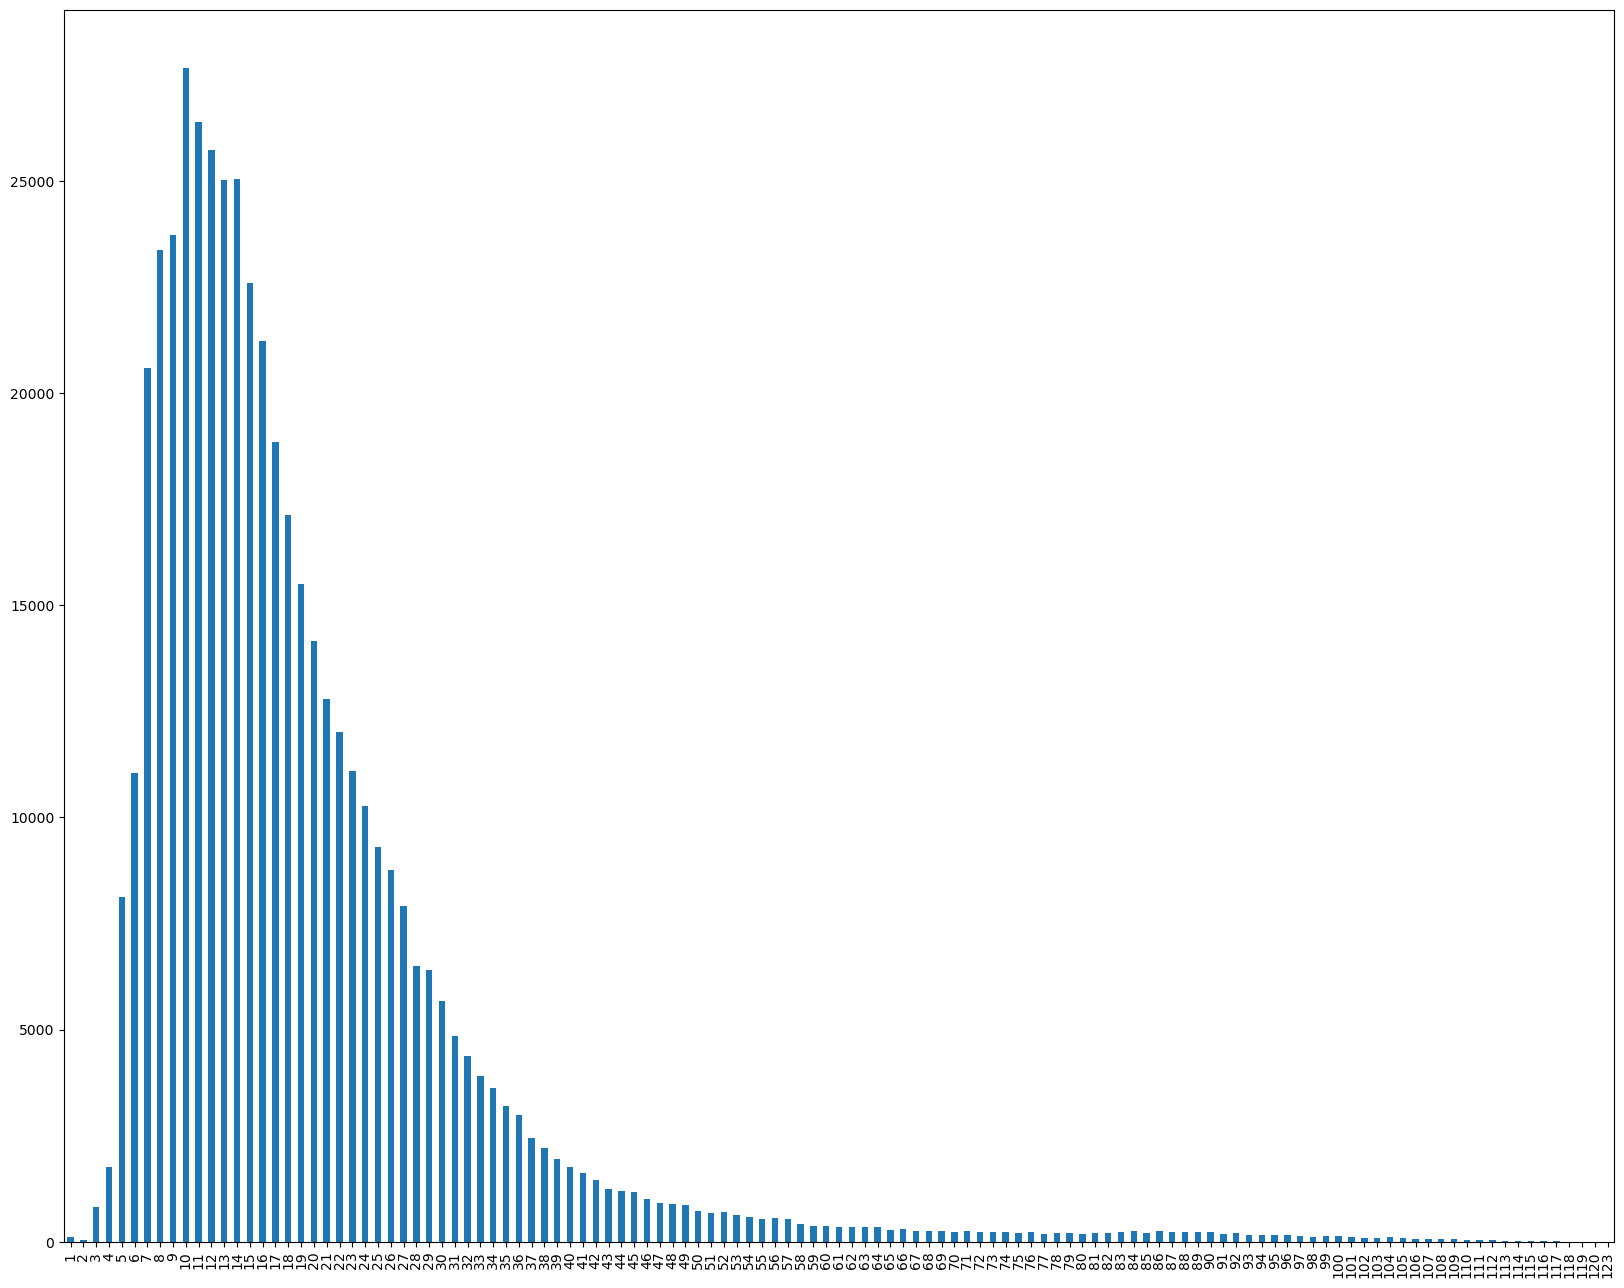

In [10]:
pd.Series({len_: len(examples) for len_, examples in by_len.items()}).plot(kind='bar', figsize=(20,16))

# Test out sentence surgery

In [ ]:
import logging
from dask.distributed import Client, LocalCluster

dask_logger = logging.getLogger("distributed.utils_perf")
dask_logger.setLevel(logging.ERROR)

dask_client = Client(LocalCluster(
    n_workers=20,
    threads_per_worker=1
))

dask_client

In [12]:
from cai_common.dict import TibetanDict

dict_ = TibetanDict()

In [40]:
import re
import copy

from cai_garland.utils.translator import Translator

In [14]:
translator = Translator("olive-cormorant-nllb/base-600M")

translator.num_beams = 50
translator.decoding_length = 200

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'NllbTokenizer'. 
The class this function is called from is 'CAINllbTokenizerFast'.


In [225]:
# words, tags = random.choice(all_sents)
words, tags = random.choice(by_len[7])
sent = re.sub("[A-Z\[\]]", "", ''.join(words)).replace('།།', '། །').strip()
sent

'སྤྲུལ་པས་རློམ་སེམས་སུ་མྱི་བྱེད།'

In [226]:
translator.translate(sent, generator_kwargs={"repetition_penalty": 2.2, "no_repeat_ngram_size": 3})

'they do not make assumptions on account of phantoms,'

In [227]:
' '.join([f"{word}-{tag}" for word, tag in zip(words, tags)])

'[CLS]- སྤྲུལ་པས་-NOUN+ADP རློམ་སེམས་-NOUN སུ་-PART མྱི་-VERB བྱེད-VERB །[SEP]-PUNCT'

In [236]:
to_replace = words[2]
print(to_replace)
dict_[to_replace]

རློམ་སེམས་


['arrogance, conceit, pride',
 'rang nyid mchog tu gyur pa zhig yin snang shar ba/',
 '[C]abhimanyati',
 '[C]mananA',
 '[C]manana',
 '(√man): [C]manyate (=samanupazyati)',
 '[C]manyanA',
 '[C]manyanu',
 '[C]manyamAnatA',
 'manyanā',
 '[C]abhimanyati',
 '[C]mananā',
 '[C]manana',
 '(√man): [C]manyate (=samanupaśyati)',
 '[C]manyanā',
 '[C]manyanu',
 '[C]manyamānatā',
 'Arrogance',
 'superiority complex',
 'self-aggrandizement.',
 'mental conceit',
 'conceited mind',
 '{C}feel conceited',
 'feel superior to',
 'mental attitude',
 'thinks',
 'fancies (himself for)',
 'thinks of',
 'minds about',
 'thinks about',
 'thinks with regard to',
 'minds',
 'puts his mind to',
 'sets above',
 'cares about',
 'conceit',
 'vain conceit',
 'minding',
 'conceitedness',
 'self-conscio']

In [250]:
random_word = random.choice(by_tag['NOUN'])
print(random_word)
dict_[random_word]

ལེ་བརྒན་རྩི་


['ordinary saffron',
 'Safflower',
 "bal po'i gur kum. Btsan-lha.",
 "le brgan te/ gur gum phal pa'i ming/",
 'Carthamus tinctorius.',
 'kusumbha']

In [251]:
changed_words = copy.deepcopy(words)
changed_words[changed_words.index(to_replace)] = random_word
changed_sent = re.sub("[A-Z\[\]]", "", ''.join(changed_words)).replace('།།', '། །').strip()
changed_sent

'སྤྲུལ་པས་ལེ་བརྒན་རྩི་སུ་མྱི་བྱེད།'

In [252]:
# meaning = "play"
# with translator.tokenizer.as_target_tokenizer():
#     meaning_tokens = translator.tokenizer.encode(meaning, add_special_tokens=False)
#     print(meaning_tokens, translator.tokenizer.decode(meaning_tokens), meaning)

In [253]:
translator.translate(
    changed_sent,
    generator_kwargs={
        "repetition_penalty": 2.2,
        "no_repeat_ngram_size": 3,
        # "force_words_ids": [meaning_tokens]
    }
)

'they do not use saffron as an emanation.'